In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import linear_model
pd.options.display.max_columns = None

In [2]:
# read in csv

orders = pd.read_csv('Orders.csv')
returns = pd.read_csv('Returns.csv')

In [3]:
orders.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless","$2,892.51",5,0.1,-$96.54,910.16,Medium
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed","$2,832.96",8,0.0,$311.52,903.04,Critical


In [4]:
### Problem 1: Dataset Import & Cleaning
# Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [5]:
orders.Profit.head()

0      $62.15
1    -$288.77
2     $919.97
3     -$96.54
4     $311.52
Name: Profit, dtype: object

In [6]:
# 1. Get rid of $ with .replace and change type to float

orders['Profit'] = orders.Profit.str.replace('[,$]','').astype('float')
orders['Sales'] = orders.Sales.str.replace('[,$]','').astype('float')

In [7]:
# ### Problem 2: Inventory Management
# - Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management.
# Your manager is making plans for next year's inventory.
# - He wants you to answer the following questions:
#     1. Is there any seasonal trend of inventory in the company?

#     2. Is the seasonal trend the same for different categories?
    
# - ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order.
#     If an order contains more than one product, there will be multiple observations of the same order.

In [8]:
# Create new columns: order_year and order_month + ship_year and ship_month usuing pd.to_datetime, dt.year and dt.month

orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders['order_year'], orders['order_month'] = orders['Order.Date'].dt.year, orders['Order.Date'].dt.month

orders['Ship.Date'] = pd.to_datetime(orders['Ship.Date'])
orders['ship_year'], orders['ship_month'] = orders['Ship.Date'].dt.year, orders['Ship.Date'].dt.month

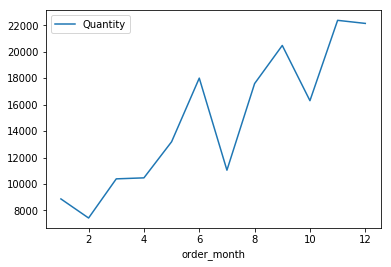

In [9]:
# 2.1
# There are peaks in inventory in June, September, November and December. 
# Inventory decreases dramatically post-Christmas (January, February), July and October.

orders[['order_month','Quantity']].groupby(['order_month']).agg(sum).plot()

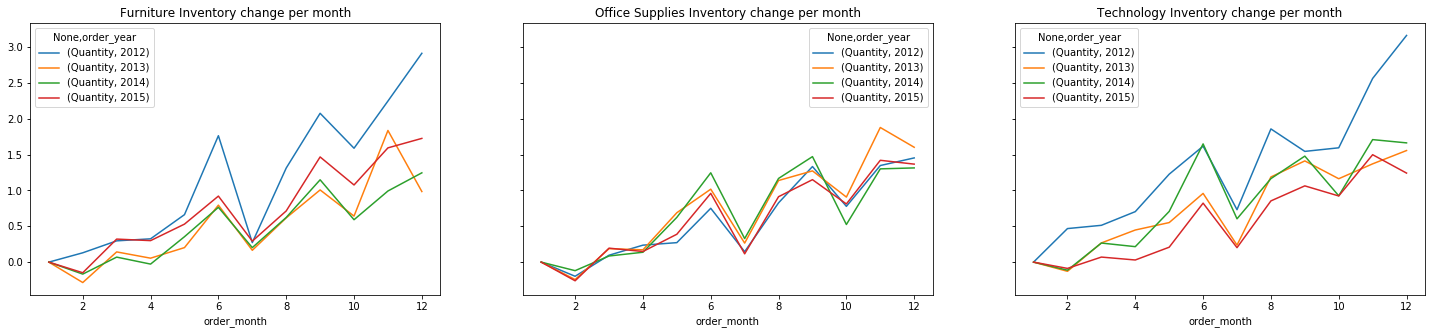

In [10]:
# 2.2    
# Yes

f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(25, 5))

orders_category_furniture = orders[['order_month','order_year','Quantity']][orders['Category'] == 'Furniture'].groupby(['order_month','order_year']).agg(sum).unstack()

(orders_category_furniture.diff().cumsum().fillna(0) / orders_category_furniture.iloc[0]).plot(ax=ax1,title='Furniture Inventory change per month')
plt.ylabel('% change')

orders_category_office_supply = orders[['order_month','order_year','Quantity']][orders['Category'] == 'Office Supplies'].groupby(['order_month','order_year']).agg(sum).unstack()

(orders_category_office_supply.diff().cumsum().fillna(0) / orders_category_office_supply.iloc[0]).plot(ax=ax2,title='Office Supplies Inventory change per month')
plt.ylabel('% change')

orders_category_tech = orders[['order_month','order_year','Quantity']][orders['Category'] == 'Technology'].groupby(['order_month','order_year']).agg(sum).unstack()

(orders_category_tech.diff().cumsum().fillna(0) / orders_category_tech.iloc[0]).plot(ax=ax3,title='Technology Inventory change per month')
plt.ylabel('% change');

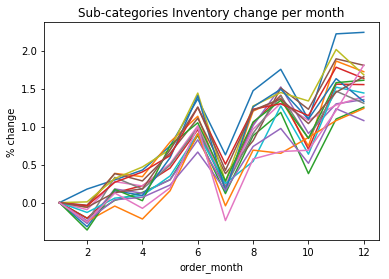

In [11]:
# Plot inventory for sub category as well, for fun. 

orders_subcategory = orders[['order_month','Quantity','Sub.Category']].groupby(['order_month','Sub.Category']).agg(sum).unstack()

(orders_subcategory.diff().cumsum().fillna(0) / orders_subcategory.iloc[0]).plot(legend=False)
plt.title('Sub-categories Inventory change per month')
plt.ylabel('% change');

In [12]:
# ### Problem 3: Why did customers make returns?
# - Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

# 	1. How much profit did we lose due to returns each year?


# 	2. How many customer returned more than once? more than 5 times?


# 	3. Which regions are more likely to return orders?


# 	4. Which categories (sub-categories) of products are more likely to be returned?

# - ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [13]:
# Merge data frames

merged = orders.merge(returns, how = 'left', left_on= 'Order.ID', right_on= 'Order ID', left_index= True)
merged.index = merged['Order.Date']

In [14]:
# 3.1 How much profit did we lose due to returns each year?

merged.groupby([merged.index.year, 'Returned'])[['Profit']].sum()

,,Profit
Order.Date,Returned,
2012,Yes,17477.26
2013,Yes,9269.89
2014,Yes,17510.63
2015,Yes,17112.97


In [15]:
# 3.2 How many customer returned more than once? more than 5 times?

returners = merged.loc[(merged['Returned'] == 'Yes')].groupby("Customer.ID").size()
print(returners[returners > 1].size)
print(returners[returners > 5].size)

547
46


In [16]:
# 3.3 Which regions are more likely to return orders?
total_returns = merged.loc[(merged['Returned'] == 'Yes')].groupby("Region_x").size()
total_returns

Region_x
Canada                15
Caribbean             69
Central Africa        17
Central America      248
Central Asia           9
Central US            74
Eastern Africa        18
Eastern Asia         131
Eastern Europe        42
Eastern US           134
North Africa          51
Northern Europe       76
Oceania              154
South America        133
Southeastern Asia    140
Southern Africa       25
Southern Asia        111
Southern Europe      112
Southern US           83
Western Africa        60
Western Asia         108
Western Europe       233
Western US           177
dtype: int64

In [17]:
total_orders = merged.groupby("Region_x").size()
total_orders

Region_x
Canada                384
Caribbean            1690
Central Africa        643
Central America      5616
Central Asia          217
Central US           2323
Eastern Africa        728
Eastern Asia         2374
Eastern Europe       1529
Eastern US           2848
North Africa         1278
Northern Europe      2204
Oceania              3487
South America        2988
Southeastern Asia    3129
Southern Africa       478
Southern Asia        2655
Southern Europe      2113
Southern US          1620
Western Africa       1460
Western Asia         2440
Western Europe       5883
Western US           3203
dtype: int64

In [18]:
worst_regions = 100* total_returns / total_orders
worst_regions.sort_values(ascending=False)

Region_x
Western US           5.526069
Eastern Asia         5.518113
Southern Europe      5.300521
Southern Africa      5.230126
Southern US          5.123457
Eastern US           4.705056
Southeastern Asia    4.474273
South America        4.451138
Western Asia         4.426230
Oceania              4.416404
Central America      4.415954
Southern Asia        4.180791
Central Asia         4.147465
Western Africa       4.109589
Caribbean            4.082840
North Africa         3.990610
Western Europe       3.960564
Canada               3.906250
Northern Europe      3.448276
Central US           3.185536
Eastern Europe       2.746893
Central Africa       2.643857
Eastern Africa       2.472527
dtype: float64

In [19]:
# 3.4 Which categories (sub-categories) of products are more likely to be returned?

(merged[merged['Returned'] == 'Yes'].groupby('Sub.Category').size()/merged.groupby('Sub.Category').size() * 100).sort_values(ascending=False)


Sub.Category
Labels         5.267205
Tables         4.761905
Accessories    4.487805
Art            4.461349
Copiers        4.453441
Binders        4.376830
Phones         4.319333
Bookcases      4.313563
Paper          4.295533
Chairs         4.280722
Furnishings    4.280279
Supplies       4.279186
Machines       4.239569
Storage        4.198851
Envelopes      4.147465
Fasteners      3.921569
Appliances     3.386912
dtype: float64

In [20]:
# Problem 4 
# 4.1
merged.Returned = merged.Returned.fillna('No')

returned_orders = merged.loc[(merged['Returned'] == 'Yes')].groupby("Order.ID").size()
returned_orders

Order.ID
AE-2014-MY7380138-42004     2
AG-2013-PO88653-41634       2
AG-2014-CM21603-41755       1
AG-2014-CP20853-41889       2
AG-2014-RD95853-41712       2
AJ-2013-SG108909-41580      2
AL-2012-EM38252-41213       3
AL-2012-SC102302-40970      1
AO-2013-JE57454-41544       3
AO-2013-SF102004-41628      1
BN-2012-RW963015-41216      2
BN-2014-KB631515-41904      1
BO-2014-KH636013-41859      3
BO-2015-MS798013-42091      3
BU-2012-EH394519-41265      1
BU-2014-CS186019-41993      3
BU-2014-MH745519-41670      3
CA-2012-AG10525140-41153    1
CA-2012-AJ10780140-41212    1
CA-2012-AZ10750140-40992    1
CA-2012-BP11095140-41261    4
CA-2012-BS11755140-41046    1
CA-2012-CC247523-41031      2
CA-2012-CM11815140-41226    1
CA-2012-CM11815140-41273    1
CA-2012-CM12715140-41177    3
CA-2012-DB13360140-41231    1
CA-2012-DP13165140-41244    3
CA-2012-EH13765140-41199    3
CA-2012-EJ13720140-41258    2
                           ..
US-2015-DB1355598-42119     1
US-2015-DH13075140-42092    7
U

In [21]:
# 3.2

merged.dtypes
merged['Ship.Date'] = pd.to_datetime(merged['Ship.Date'])
# new feature
merged['process_time'] = merged['Ship.Date'] - merged['Order.Date']

In [22]:
# 3.3

# returns per product ID
returned_times = merged[merged['Returned'] == 'Yes'].groupby('Product.ID').size()
returned_times = returned_times.reset_index()
returned_times.columns = ['Product.ID', 'Returned_Times']

merged = merged.merge(returned_times,how='left',on='Product.ID').fillna(0)
merged

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,order_year,order_month,ship_year,ship_month,Returned,Order ID,Region_y,process_time,Returned_Times
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.00,62.15,40.770,High,2014,11,2014,11,No,0,0,2 days,0.0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,0.0,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.10,-288.77,923.630,Critical,2014,2,2014,2,No,0,0,2 days,2.0
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,0.0,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.10,919.97,915.490,Medium,2014,10,2014,10,No,0,0,1 days,2.0
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,0.0,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.10,-96.54,910.160,Medium,2014,1,2014,1,No,0,0,2 days,0.0
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,0.0,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.00,311.52,903.040,Critical,2014,11,2014,11,No,0,0,1 days,0.0
5,22732,IN-2014-JM156557-41818,2014-06-28,2014-07-01,Second Class,JM-156557,Jim Mitchum,Corporate,0.0,Sydney,New South Wales,Australia,Oceania,Asia Pacific,TEC-PH-5842,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.68,5,0.10,763.28,897.350,Critical,2014,6,2014,7,No,0,0,3 days,1.0
6,30570,IN-2012-TS2134092-41219,2012-11-06,2012-11-08,First Class,TS-2134092,Toby Swindell,Consumer,0.0,Porirua,Wellington,New Zealand,Oceania,Asia Pacific,FUR-CH-5378,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.08,4,0.00,564.84,894.770,Critical,2012,11,2012,11,No,0,0,2 days,5.0
7,31192,IN-2013-MB1808592-41378,2013-04-14,2013-04-18,Standard Class,MB-1808592,Mick Brown,Consumer,0.0,Hamilton,Waikato,New Zealand,Oceania,Asia Pacific,FUR-TA-3764,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.84,6,0.00,996.48,878.380,High,2013,4,2013,4,No,0,0,4 days,0.0
8,40099,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,FUR-BO-5957,Furniture,Bookcases,"Sauder Facets Collection Library, Sky Alder Fi...",341.96,2,0.00,54.71,25.270,High,2014,11,2014,11,No,0,0,2 days,0.0
9,36258,CA-2012-AB10015140-40974,2012-03-06,2012-03-07,First Class,AB-100151404,Aaron Bergman,Consumer,98103.0,Seattle,Washington,United States,Western US,USCA,FUR-CH-4421,Furniture,Chairs,"Global Push Button Manager's Chair, Indigo",48.71,1,0.20,5.48,11.130,High,2012,3,2012,3,No,0,0,1 days,1.0


In [50]:
modelframe = merged.drop(['Row.ID', 'Order.ID', 'Customer.ID', 'Product.ID', 'Order ID'], axis=1)

In [51]:
modelframe.dtypes

Order.Date         datetime64[ns]
Ship.Date          datetime64[ns]
Ship.Mode                  object
Customer.Name              object
Segment                    object
Postal.Code               float64
City                       object
State                      object
Country                    object
Region_x                   object
Market                     object
Category                   object
Sub.Category               object
Product.Name               object
Sales                     float64
Quantity                    int64
Discount                  float64
Profit                    float64
Shipping.Cost             float64
Order.Priority             object
order_year                  int64
order_month                 int64
ship_year                   int64
ship_month                  int64
Returned                   object
Region_y                   object
process_time      timedelta64[ns]
Returned_Times            float64
dtype: object

In [52]:
pd.DataFrame({'col': [x for x in modelframe.columns],
              'type': [modelframe.dtypes[x] for x in range(len(modelframe.columns))],
              'unique': [len(modelframe[x].unique()) for x in modelframe.columns]}).sort_values(by='unique',ascending=False)


,col,type,unique
14,Sales,float64,20049
17,Profit,float64,16578
18,Shipping.Cost,float64,16452
13,Product.Name,object,3788
6,City,object,3650
1,Ship.Date,datetime64[ns],1464
0,Order.Date,datetime64[ns],1430
7,State,object,1102
3,Customer.Name,object,796
5,Postal.Code,float64,632


In [53]:
modelframe['Returned_Times'] = modelframe['Returned_Times'].astype('int64')
modelframe[['Postal.Code','order_month','order_year','ship_month','ship_year']] = modelframe[['Postal.Code','order_month','order_year','ship_month','ship_year']].astype('category')


modelframe['process_time'] = (modelframe['process_time']/24/3600/1000000000).astype('int64')

modelframe = modelframe.drop(columns=['Ship.Date','Order.Date'])

for col in modelframe.columns:
    if modelframe[col].dtypes  == 'O':
        modelframe[col] = modelframe[col].astype('category')

In [54]:
category_list = []
for col in modelframe.columns:
    if modelframe[col].dtypes.name == 'category':
        if col == 'Returned': continue
        category_list.append(col)

pd.DataFrame({'col': [x for x in modelframe.columns],
      'type': [modelframe.dtypes[x] for x in range(len(modelframe.columns))],
      'unique': [len(modelframe[x].unique()) for x in modelframe.columns]}).sort_values(by='unique',ascending=False)

,col,type,unique
12,Sales,float64,20049
15,Profit,float64,16578
16,Shipping.Cost,float64,16452
11,Product.Name,category,3788
4,City,category,3650
5,State,category,1102
1,Customer.Name,category,796
3,Postal.Code,category,632
6,Country,category,165
14,Discount,float64,27


In [55]:
modelframe = pd.get_dummies(modelframe, columns = category_list)

In [56]:
modelframe.shape

(51290, 10258)

In [57]:
features = modelframe.drop(columns=['Returned']).copy()
returned = modelframe['Returned'].copy()

x, x_test, y, y_test = ms.train_test_split(features, returned, 
                                                       test_size=1.0/5, random_state=0)

In [59]:
logit = linear_model.LogisticRegression()

In [60]:
logit.fit(x,y)

/Users/macpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
logit.score(x,y)

1.0

In [63]:
logit.score(x_test,y_test)

1.0